In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import gudhi as gd
from gudhi.wasserstein import wasserstein_distance
from gudhi import bottleneck_distance

def analyze_persistence_series(price_series, policy_data, policy_columns, 
                                lag_dim=5, window_size=30, max_edge_length=50.0, verbose=True):
    import numpy as np
    import pandas as pd
    import gudhi as gd
    from tqdm import tqdm

    # Ensure price_series is a pandas Series
    if isinstance(price_series, np.ndarray):
        price_series = pd.Series(price_series)

    # Construct lagged price series for embedding
    price_lags = np.vstack([
        price_series[i:-(lag_dim + 1 - i)] for i in range(1, lag_dim + 1)
    ]).T

    # Align current price values with lagged data
    price_current = price_series[lag_dim:].reset_index(drop=True)[:len(price_lags)].values.reshape(-1, 1)

    # Select and align relevant policy variables
    policy_used = policy_data[policy_columns]
    policy_current = policy_used.iloc[lag_dim:lag_dim + len(price_lags)].reset_index(drop=True)

    # Combine price, lagged series, and policy data into one point cloud
    cloud = np.hstack([price_current, price_lags, policy_current.values])
    dates = policy_data["Date"].iloc[lag_dim:lag_dim + len(price_lags)].reset_index(drop=True)

    # Compute persistent homology norms (L1) for H1 features
    def compute_persistence_norms(cloud_slice):
        rips = gd.RipsComplex(points=cloud_slice, max_edge_length=max_edge_length)
        st = rips.create_simplex_tree(max_dimension=2)
        persistence = st.persistence()
        h1_l1 = h1_l2 = h0_l1 = h0_l2 = 0
        for dim, (birth, death) in persistence:
            if not np.isfinite(death): 
                continue
            life = death - birth
            if dim == 1:  # focus on 1-dimensional features (loops)
                h1_l1 += life
                h1_l2 += life ** 2
            elif dim == 0:
                h0_l1 += life
                h0_l2 += life ** 2
        return {
            "H1_L1": h1_l1,
            "H1_L2": np.sqrt(h1_l2),
            # H0 metrics commented out (not used in this analysis)
        }

    # Extract H1 persistence diagram for each window
    def get_h1_diagram(cloud_slice):
        rips = gd.RipsComplex(points=cloud_slice, max_edge_length=max_edge_length)
        st = rips.create_simplex_tree(max_dimension=2)
        diag = st.persistence()
        return np.array([pair[1] for pair in diag if pair[0] == 1 and np.isfinite(pair[1][1])])

    # Slide window across time series to compute norms and diagrams
    norms, diagrams = [], []
    iterator = tqdm(range(len(cloud) - window_size)) if verbose else range(len(cloud) - window_size)
    for i in iterator:
        subcloud = cloud[i:i+window_size]
        norms.append(compute_persistence_norms(subcloud))
        diagrams.append(get_h1_diagram(subcloud))

    return pd.DataFrame(norms), diagrams, dates[window_size:]


100%|███████████████████████████████████████████████████████████████████████████████| 162/162 [00:00<00:00, 652.04it/s]


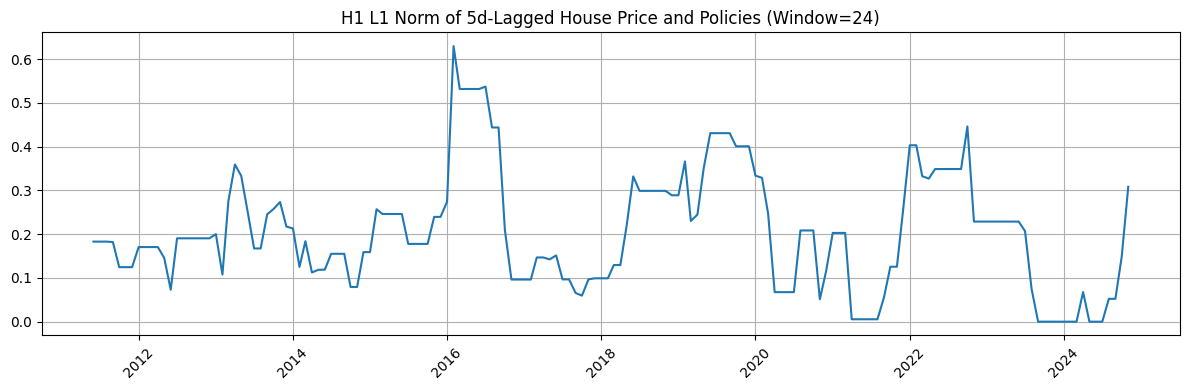

In [2]:
df = pd.read_csv("North_West_Housing_Policy_Dataset_sd.csv", parse_dates=["Date"])
price_series = df["Average_Housing_Price"].values
policy_columns = ['Weekly_Earnings','Employment_Rate','Benefit Caseload','Housing Supply','Euro Rate','Interest Rate']
lag_dim=5
window_size=24

norm_df, diagrams, aligned_dates = analyze_persistence_series(
    price_series=price_series,
    policy_data=df,
    policy_columns=policy_columns,
    lag_dim=lag_dim,
    window_size=window_size,
    verbose=True
)


plt.figure(figsize=(12, 4))
plt.plot(aligned_dates, norm_df["H1_L1"])
plt.title("H1 L1 Norm of 5d-Lagged House Price and Policies (Window=24)")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


In [3]:
norm_df['H1_L1'].to_csv('norm-NW.csv')

In [5]:
norm = pd.read_csv("norm-NW.csv", parse_dates=["Date"])

In [6]:
norm_df.describe()

,H1_L1,H1_L2
count,162.000000,162.000000
mean,0.204788,0.128550
std,0.132769,0.081018
min,0.000000,0.000000
25%,0.108849,0.070289
50%,0.190557,0.124896
75%,0.274859,0.158047
max,0.629908,0.383808


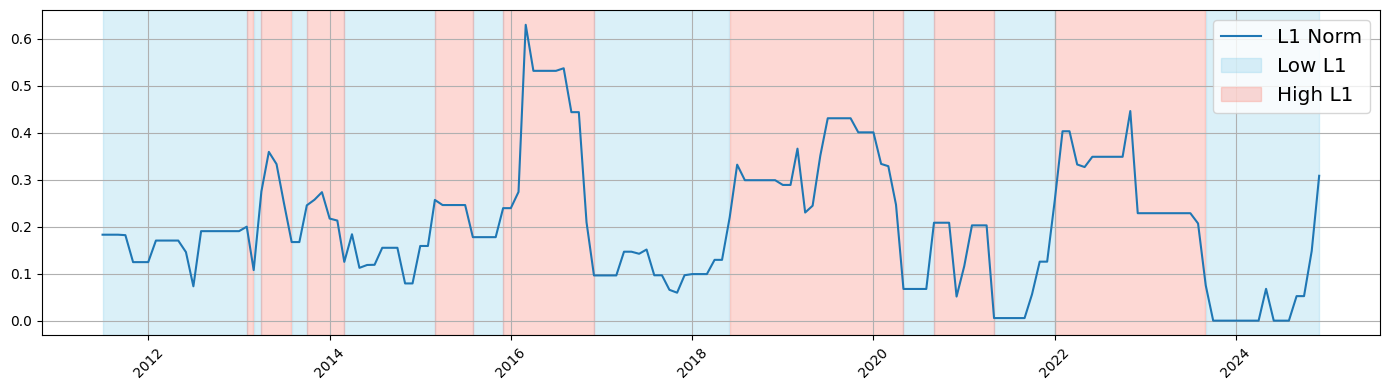

In [10]:
# Figure 4.3 L₁ Norm of joint embedding point Time Series and High/Low L₁ Norm Periods (Northwest)

import matplotlib.pyplot as plt
import pandas as pd

norm_df["Date"] = norm["Date"]



high_periods_filtered = [
    ("2013-02-01", "2013-02-28"),
    ("2013-04-01", "2013-07-31"),
    ("2013-10-01", "2014-02-28"),
    ("2015-03-01", "2015-07-31"),
    ("2015-12-01", "2016-11-30"),
    ("2018-06-01", "2020-04-30"),
    ("2020-09-01", "2021-04-30"),
    ("2022-01-01", "2023-08-31")
]
low_periods_filtered = [
    ("2011-07-01", "2013-01-31"),
    ("2013-03-01", "2013-03-31"),
    ("2013-08-01", "2013-09-30"),
    ("2014-03-01", "2015-02-28"),
    ("2015-08-01", "2015-11-30"),
    ("2016-12-01", "2018-05-31"),
    ("2020-05-01", "2020-08-31"),
    ("2021-05-01", "2021-12-31"),
    ("2023-09-01", "2024-11-30")
]



# Plot L1 norm time series
plt.figure(figsize=(14, 4))
plt.plot(norm_df["Date"], norm_df["H1_L1"], label="L1 Norm")

# Highlight low periods with shaded regions
for start, end in low_periods_filtered:
    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), 
                color='skyblue', alpha=0.3, label="Low L1")

# Highlight high periods with shaded regions
for start, end in high_periods_filtered:
    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), 
                color='salmon', alpha=0.3, label="High L1")

# Remove duplicate legend labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize='x-large')

# Format axis for readability
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

